In [2]:
import requests

def post_ocr_batch(image_path: str, url: str = "https://5fy82rdaydg7yb-8000.proxy.runpod.net/ocr-batch"):
    """
    Sends a POST request to the OCR batch endpoint with the given image file.

    Args:
        image_path (str): Path to the image file to upload.
        url (str): The OCR batch endpoint URL.

    Returns:
        requests.Response: The response object from the server.
    """
    with open(image_path, "rb") as f:
        files = {'files': (image_path, f, 'image/png')}
        headers = {
            'accept': 'application/json'
        }
        response = requests.post(url, headers=headers, files=files)
    return response


In [3]:
paddle = post_ocr_batch(r"construction-invoice-template-1x.png")

In [6]:
paddle.text

'[{"filename":"construction-invoice-template-1x.png","result":{"rec_texts":["Zylker Masterworks","14B, Northern Street","Greater South Avenue","量","New York 10001","U.S.A","INVOICE","Invoice#","Bill To","INV-000001","Michael Williams","789 Oak Ave","Chicago","60601IL","United States","Invoice Date","Terms","Due Date","01 Jun 2024","Net 30","O1 Jul 2024","井","Item & Description","Qty","Rate","Tax%","Amount","1","Deck and patio construction","80.00","21.00","10.00","1,680.00","Pressure-treated composite decking","Square feet","2","Fixture installation","7.00","150.00","10.00","1,050.00","(Sinks, toilets, showers)","Piece","3","Air conditioning systems installation","1.00","3,750.00","10.00","3,750.00","Heating, ventilation, and air conditioning installation","Sub Total","6,480.00","Thanks for your business.","Discount(6.00%)","(-)388.80","Shipping charge","500.00","Total","$7,200.32","Balance Due","$7,200.32","Terms & Conditions","All services provided are subject to the terms and condit

In [7]:
system_prompt = """
You are a construction invoice expert and deterministic JSON emitter.

You will be given:
1) OCR text tokens with their (page, x1, y1, x2, y2) coordinates and reading order.
2) The raw concatenated text, if available.

YOUR TASK
Extract invoice data and return EXACTLY ONE JSON object that matches the schema and key order below. 
- Output JSON ONLY. No prose, no markdown, no code fences, no comments.
- Do not add, remove, or rename keys.
- Use null for unknown values (do NOT omit keys).
- Dates must be ISO-8601 (YYYY-MM-DD).
- All amounts/rates must be numbers (no $, commas, or %). Convert “6%” → 0.06; “$1,234.50” → 1234.5.
- Booleans are true/false (lowercase).
- line_items must have ≥1 item.
- Keep the exact key order shown.

SCHEMA (exact keys and order):
{
  "invoice_id": "<string>",
  "invoice_date": "<YYYY-MM-DD>",
  "due_date": "<YYYY-MM-DD or null>",
  "currency": "<3-letter code>",
  "vendor": {
    "name": "<string>",
    "address": "<string or null>",
    "tax_id": "<string or null>",
    "contact": {
      "email": "<string or null>",
      "phone": "<string or null>"
    }
  },
  "bill_to": {
    "name": "<string>",
    "project_name": "<string or null>",
    "project_number": "<string or null>",
    "job_site_address": "<string or null>"
  },
  "purchase_order": "<string or null>",
  "payment_terms": "<string or null>",
  "line_items": [
    {
      "line_id": <integer>,
      "description": "<string>",
      "quantity": <number>,
      "unit": "<string>",
      "unit_price": <number>,
      "line_total": <number>,
      "cost_code": "<string or null>",
      "category": "<material|labor|equipment|subcontractor or null>",
      "taxable": <true|false|null>
    }
  ],
  "subtotal": <number>,
  "taxes": [
    {
      "name": "<string>",
      "rate": <number>,
      "amount": <number>
    }
  ],
  "retainage": {
    "percent": <number or null>,
    "amount": <number or null>
  },
  "adjustments": [
    {
      "type": "<credit|debit|discount|other>",
      "description": "<string>",
      "amount": <number>
    }
  ],
  "total": <number>
}

HOW TO USE COORDINATES (for better accuracy; do NOT include coordinates in the output):
- Prefer values physically nearest to their labels. If multiple candidates exist, choose the one to the RIGHT of the label on the SAME row; if not found, choose the one DIRECTLY BELOW within a small vertical window.
- Totals usually appear near the bottom-right of the last page. Prefer the value closest to labels like “Total”, “Invoice Total”, “Amount Due”.
- Subtotal/Tax/Retainage/Adjustments typically stack above the grand total in a right-aligned summary block. Map each line by label proximity.
- Vendor vs Bill-To:
  - VENDOR (issuer/remit-from) commonly top-left; look for “From”, “Remit To”, logos near it, vendor tax ID nearby.
  - BILL_TO (customer) labeled “Bill To”, “Sold To”, “Customer”, often top-right or a dedicated block.
- Project fields:
  - project_name / project_number / job_site_address are often near “Project/Job/Job #/Project #/Job Site/Site Address”.
- PO and payment_terms:
  - Look for “PO”, “P.O.”, “Purchase Order”.
  - Payment terms examples: “Net 30”, “Due on receipt”.

LINE-ITEM TABLE DETECTION:
- Identify the main line-item table by headers such as any of: Description/Item, Qty/Quantity, U/M/UOM, Rate/Unit Price/Price, Amount/Line Total, Tax.
- Descriptions may wrap to multiple lines; merge wrapped lines belonging to the same row (same x-range; next line starts aligned under Description without new numeric columns).
- Compute or verify: line_total ≈ quantity * unit_price (round to 2 decimals). If a row displays all three, keep the displayed line_total; if missing one component, compute the missing value when unambiguous.
- Category inference (material|labor|equipment|subcontractor):
  - material: items like concrete, rebar, pipe, fasteners, consumables.
  - labor: hours/crew/installer, UOM like HR.
  - equipment: rental, mobilization, crane, lift, machine hours.
  - subcontractor: another company named on a line, or “Subcontract”, “Sub”, “Trade”.
- taxable per-line: true if explicitly indicated, if a tax column shows nonzero, or if in a taxable group; false if marked non-taxable; otherwise null.

RETAINAGE & ADJUSTMENTS:
- If retainage is shown as a negative line or separate row, set retainage.amount to the absolute held-back value and retainage.percent to the stated % (decimal). If only the percent is given, compute amount when subtotal is known.
- Adjustments include credits, debits, early payment discounts. Use type one of: credit, debit, discount, other.

DISAMBIGUATION & TIE-BREAKERS:
- Prefer values with explicit labels over unlabeled numbers.
- If multiple candidates remain, choose the one with the closest centroid distance to the label; break further ties by larger font or boldness if hinted by OCR; else top-most then left-most.
- When date formats are ambiguous (e.g., 03/04/2025), use the field’s label (“Invoice Date”, “Due Date”) and local conventions if indicated; otherwise assume MM/DD/YYYY and normalize to YYYY-MM-DD.

NORMALIZATION RULES:
- Strip currency symbols and thousands separators. Convert parentheses to negative (e.g., (123.45) → -123.45).
- Convert percentages to decimals (e.g., 10% → 0.10).
- Trim whitespace; collapse multiple spaces.
- If a field is truly absent, use null (do not fabricate).

VALIDATION (internal; do not output messages):
- Ensure numeric types for amounts/rates and dates in ISO-8601.
- Ensure line_items length ≥ 1.
- Prefer internal arithmetic consistency: subtotal ≈ sum(line_total); total ≈ subtotal + sum(taxes.amount) + sum(adjustments.amount) ± retainage.amount (depending on presentation). If the document explicitly states totals, favor the stated values; do not invent numbers.

OUTPUT
Return EXACTLY one JSON object that matches the schema and constraints above. No extra text before or after the JSON.
"""

In [20]:
import requests

def generate_text(prompt: str, system: str = system_prompt, max_new_tokens: int = 2048, url: str = "http://localhost:8000/generate"):
    """
    Sends a POST request to the /generate endpoint of the FastAPI server.

    Args:
        prompt (str): The prompt to send to the model.
        system (str): The system prompt.
        max_new_tokens (int): Maximum number of new tokens to generate.
        url (str): The endpoint URL.

    Returns:
        dict: The JSON response from the server.
    """
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json"
    }
    payload = {
        "prompt": prompt,
        "system": system,
        "max_new_tokens": max_new_tokens
    }
    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    return response.json()

In [24]:
import base64
import mimetypes
from pathlib import Path
from typing import List, Dict, Any, Optional
import requests


def _to_data_uri(image_ref: str) -> str:
    if image_ref.startswith("http://") or image_ref.startswith("https://") or image_ref.startswith("data:image"):
        return image_ref
    p = Path(image_ref)
    mime, _ = mimetypes.guess_type(p.name)
    if not mime:
        mime = "image/png"
    with open(p, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"


def generate_text(
    prompt: Optional[str] = None,
    system: str = system_prompt,
    max_new_tokens: int = 2048,
    url: str = "http://localhost:8000/generate",
    image: Optional[str] = None,
    messages: Optional[List[Dict[str, Any]]] = None,
):
    """
    Sends a POST request to the /generate endpoint (multimodal-capable).

    Provide messages directly, or a prompt with optional image (path/URL/data URI).
    """
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json",
    }

    if messages is None:
        content: List[Dict[str, Any]] = []
        if image:
            content.append({"type": "image", "image": _to_data_uri(image)})
        if prompt:
            content.append({"type": "text", "text": prompt})

        msgs: List[Dict[str, Any]] = []
        if system:
            msgs.append({"role": "system", "content": system})
        msgs.append({"role": "user", "content": content})
    else:
        msgs = list(messages)
        if system and (not msgs or msgs[0].get("role") != "system"):
            msgs = [{"role": "system", "content": system}] + msgs

    payload = {
        "messages": msgs,
        "max_new_tokens": max_new_tokens,
    }

    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    return response.json()


In [25]:
# with an image (local path, URL, or data URI)
llm_response = generate_text(
    # prompt="Describe this image.",
    image="construction-invoice-template-1x.png"
)
print(llm_response["response"])

{
  "invoice_id": "INV-000001",
  "invoice_date": "2024-06-01",
  "due_date": "2024-07-01",
  "currency": "USD",
  "vendor": {
    "name": "Zylker Masterworks",
    "address": "14B, Northern Street Greater South Avenue New York 10001 U.S.A",
    "tax_id": null,
    "contact": {
      "email": null,
      "phone": null
    }
  },
  "bill_to": {
    "name": "Michael Williams",
    "project_name": null,
    "project_number": null,
    "job_site_address": "789 Oak Ave Chicago 60601 IL United States"
  },
  "purchase_order": null,
  "payment_terms": "Net 30",
  "line_items": [
    {
      "line_id": 1,
      "description": "Deck and patio construction Pressure-treated composite decking",
      "quantity": 80.00,
      "unit": "Square feet",
      "unit_price": 21.00,
      "line_total": 1680.00,
      "cost_code": null,
      "category": "material",
      "taxable": true
    },
    {
      "line_id": 2,
      "description": "Fixture installation (Sinks, toilets, showers)",
      "quantity":

In [27]:
import datasets 
ds = datasets.load_dataset("chainyo/rvl-cdip-invoice")

/root/invoice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 19947/19947 [00:04<00:00, 4832.93 examples/s]


In [30]:
ds = ds['train']

In [32]:
import uuid, base64, io, json
from typing import List, Dict, Any
from PIL import Image


def pil_to_data_uri(img: Image.Image, mime: str = "image/png") -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:{mime};base64,{b64}"


records: List[Dict[str, Any]] = []
num = min(10, len(ds))
for i in range(num):
    row = ds[i]
    img = row["image"]
    image_id = row.get("id") if isinstance(row, dict) and "id" in row else f"rvl_cdip_{i}_{uuid.uuid4().hex[:8]}"
    data_uri = pil_to_data_uri(img)
    try:
        resp = generate_text(image=data_uri, max_new_tokens=1024)
        output = resp["response"]
    except Exception as e:
        output = {"__error__": str(e)}
    records.append({"image": data_uri, "image_id": image_id, "output": output})


In [45]:
for ix, rec in enumerate(records):
    rec['image'] = ds[ix]['image']


In [49]:
records[0]

{'image': <PIL.Image.Image image mode=L size=754x1000>,
 'image_id': 'rvl_cdip_0_fcff7c43',
 'output': '{\n  "invoice_id": "57-WNL 801794",\n  "invoice_date": "1994-11-30",\n  "due_date": null,\n  "currency": "$",\n  "vendor": {\n    "name": "Weis Markets",\n    "address": "1000 S. 2nd Street Sunbury Pa. 17801",\n    "tax_id": null,\n    "contact": {\n      "email": null,\n      "phone": null\n    }\n  },\n  "bill_to": {\n    "name": null,\n    "project_name": null,\n    "project_number": null,\n    "job_site_address": null\n  },\n  "purchase_order": null,\n  "payment_terms": null,\n  "line_items": [\n    {\n      "line_id": 1,\n      "description": "Extend current merchandising and private label agreement from 9/30/95 until 6/30/97.",\n      "quantity": null,\n      "unit": null,\n      "unit_price": null,\n      "line_total": 421000.00,\n      "cost_code": "04-74-1700-8915-816",\n      "category": null,\n      "taxable": null\n    }\n  ],\n  "subtotal": 421000.00,\n  "taxes": [],\n  

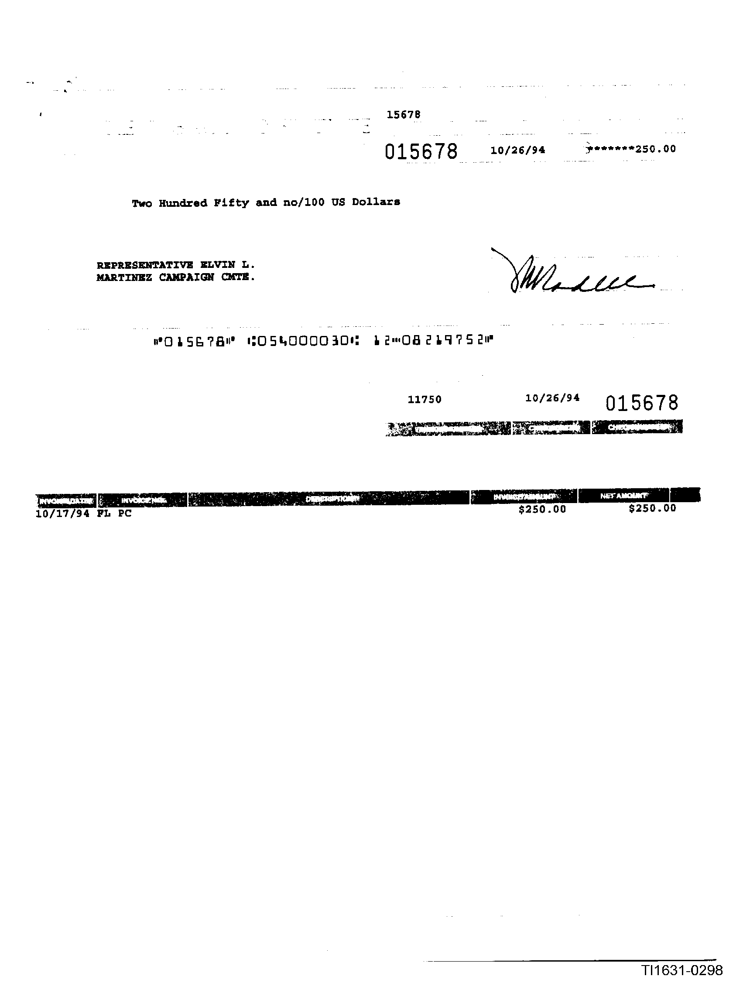

In [50]:
records[-1]['image']